In [3]:
####Rene 7_30_2021

####Replicate isotope pattern algorithm in python for a single file and peak pair.

# Import the os module
import os
import pandas as pd
import numpy as np
# Change the current working directory
os.chdir('/Users/boiteaur/Desktop/CoreMS_development/CoreMS')

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters


#set file here
file_location = "tests/tests_data/rmb_161221_kansas_h2o_2"

#Set peak detection threshold method
MSParameters.mass_spectrum.noise_threshold_method = 'relative_abundance'
MSParameters.mass_spectrum.noise_threshold_min_relative_abundance = 1

MSParameters.mass_spectrum.noise_threshold_method = 'auto'
MSParameters.mass_spectrum.noise_threshold_min_s2n = 10

#Parser for thermo RAW files. 
parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location)

In [4]:

t_ion_chromatogram = parser.get_tic()

t_ion_subset=t_ion_chromatogram[(t_ion_chromatogram["Time"]>8) & (t_ion_chromatogram["Time"]<9)]

print(t_ion_chromatogram['Time'])

print(type(parser))

print(parser.initial_scan_number)
print(parser.final_scan_number)



1         0.000454
2         0.035162
3         0.039766
4         0.042391
5         0.045043
           ...    
10422    35.012427
10423    35.015081
10424    35.017738
10425    35.020394
10426    35.023051
Name: Time, Length: 10426, dtype: object
<class 'corems.mass_spectra.input.rawFileReader.ImportMassSpectraThermoMSFileReader'>
1
10426


<AxesSubplot:xlabel='Time'>

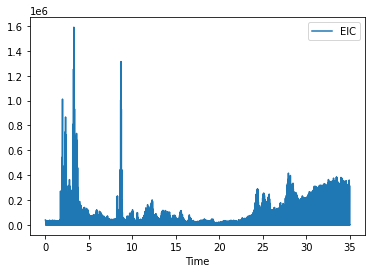

In [131]:
#Function for obtaining extracted ion chromatogram. It is quite slow. 

def get_EIC(parser,mass,dmz,scanrange):
    EIC = pd.DataFrame(index=scanrange, columns=['Time', 'EIC'])

    for scan in scanrange:    

        scanStatistics = parser.iRawDataPlus.GetScanStatsForScanNumber(scan)
        EIC.loc[scan, 'Time'] = scanStatistics.StartTime

        #create intensity data frame based on current scan:
        current = pd.DataFrame(parser.get_data(scan,1,scan_type="Profile"))
        #take subset of data frame and place in EIC
        subset = current[abs(current['m/z'] - mass) < dmz]
        EIC.loc[scan,'EIC']=(sum(subset['Peak Height']))
    return(EIC)

#Test
scanrange=range(parser.initial_scan_number,parser.final_scan_number)
mass=321
dmz=1
EIC=get_EIC(parser,mass,dmz,scanrange)
EIC.plot.line(x='Time',y='EIC')


<AxesSubplot:xlabel='Time'>

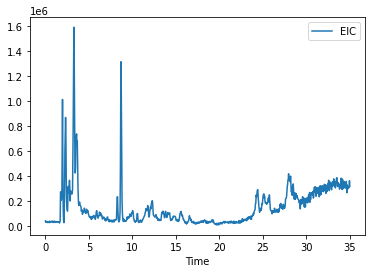

In [132]:
#Get MS1 scans numbers only.
first_scan = parser.scans[0]
final_scan =parser.scans[1]
scanrange = range(first_scan, final_scan + 1)

MSn = pd.DataFrame(index=scanrange, columns=['Time', 'n'])

#print(parser.get_tic())
for scan in range(parser.initial_scan_number, parser.final_scan_number):
    scanStatistics = parser.iRawDataPlus.GetScanStatsForScanNumber(scan)
    MSn.loc[scan, 'Time'] = scanStatistics.StartTime
    MSn.loc[scan,'n'] = parser.get_scan_header(scan)['Master Scan Number:']

MS1scans=MSn[MSn.n=='0']

#Test
scanrange=MS1scans.index.values
mass=321
dmz=1
EIC=get_EIC(parser,mass,dmz,scanrange)
EIC.plot.line(x='Time',y='EIC')



<AxesSubplot:xlabel='Time 59Co'>

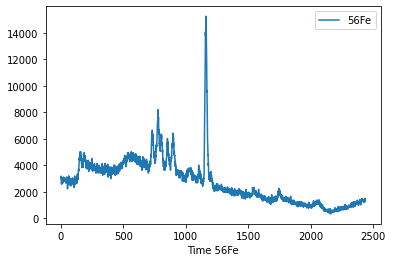

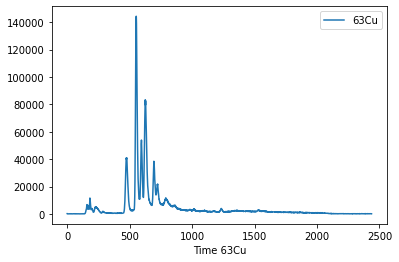

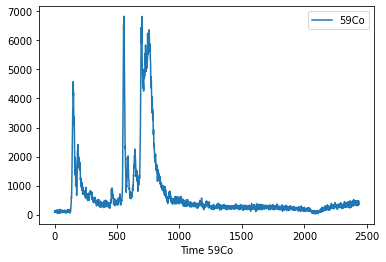

In [46]:
#Import LC-ICPMS data and plot it:

icpfile_location = "tests/tests_data/161220_soils_hypercarb_3_kansas_qH2O.csv"
icp=pd.read_csv(icpfile_location)

icp.plot.line(x='Time 56Fe',y='56Fe')
icp.plot.line(x='Time 63Cu',y='63Cu')
icp.plot.line(x='Time 59Co',y='59Co')

#Note that, icp data 


<AxesSubplot:xlabel='Time 63Cu'>

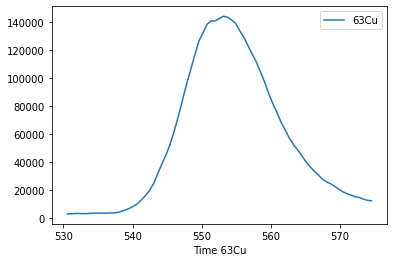

In [68]:
#Pick out a time-slice of the ICPMS data that will be correlated w/ EIC data. 

timestart=530
timestop=575
icpi="63Cu"
icpt="Time " + icpi
icpslice=icp[icp[icpt].between(timestart,timestop)]

icpslice.plot.line(x=icpt,y=icpi)


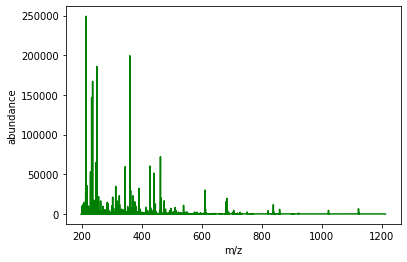

189
203.02267974195436
204.93324092875253
205.03833118230298
205.08581629013926
208.11797794602288
212.12812693289612
213.12345991305867
214.9169894379706
214.91767151280197
215.13902030518813
215.92084204441423
216.14224554955598
217.01317473720712
217.0382602623647
217.11829641862906
218.1386506347155
218.91041888012558
218.94884018812124
219.01750459800436


In [167]:
#Correlate every ESIMS mz detected across the time range with the metal intensity. 
#This section obtains EIC's for every m/z over the time range. 

scans=MS1scans[MSn["Time"].between(timestart/60,timestop/60)].index.tolist()
parser.chromatogram_settings.scans = scans
AverageMS = parser.get_average_mass_spectrum(scans)
AverageMS.plot_mz_domain_profile()
plt.show()

print(AverageMS.mz_exp.size)

scanrange=scans

EICdic = {}

for mz in AverageMS.mz_exp[1:20]:
    EIC = pd.DataFrame(index=scanrange, columns=['Time', 'EIC'])
    mass=mz
    dmz=0.002
    print(mz)
    EIC=get_EIC(parser,mass,dmz,scanrange)
    EICdic[mz]=EIC



<AxesSubplot:xlabel='Time'>

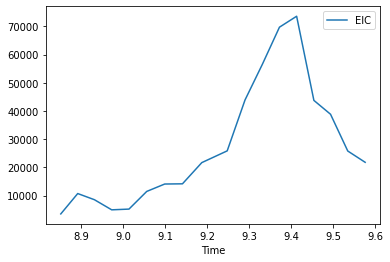

In [169]:
###This section is not finished: Goal is to 

curr=EICdic[203.02267974195436]

#need to account for any offset in data. Here, will do it manually, but ultimately want to use internal std.

curr.plot.line(x='Time',y='EIC')


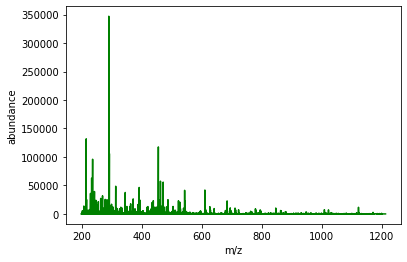

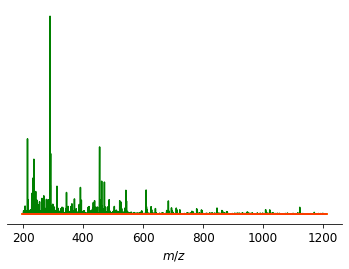

In [17]:
    # sums all the mass spectra
    mass_spectrum = parser.get_average_mass_spectrum()

    mass_spectrum.plot_mz_domain_profile()
    plt.show()
    
    mass_spectrum.plot_profile_and_noise_threshold()
    plt.show()

# sums scans in selected range
parser.scans = (1, 5)
#mass_spectrum = parser.get_average_mass_spectrum()


Loading molecular formula database: 0it [00:00, ?it/s]'runworker'  120.02 ms
Loading molecular formula database: 65686it [00:04, 15791.22it/s]
Started molecular formula search for class {"O": 30}, (de)protonated : 100%|██████████| 30/30 [00:00<00:00, 168.93it/s]
'run_molecular_formula'  4541.50 ms
76 assigned peaks and 177 unassigned peaks, total  = 30.04 %, relative abundance = 21.87 %, RMS error (best candidate) (ppm) = 1.575


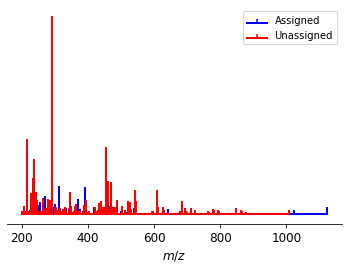

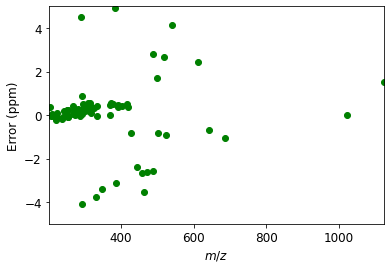

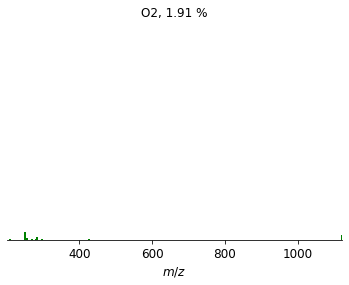

In [21]:
mass_spectrum.molecular_search_settings.error_method = 'None'
mass_spectrum.molecular_search_settings.min_ppm_error = -5
mass_spectrum.molecular_search_settings.max_ppm_error = 5

mass_spectrum.molecular_search_settings.url_database = None
mass_spectrum.molecular_search_settings.min_dbe = 0
mass_spectrum.molecular_search_settings.max_dbe = 50

mass_spectrum.molecular_search_settings.usedAtoms['C'] = (1, 100)
mass_spectrum.molecular_search_settings.usedAtoms['H'] = (4, 200)
mass_spectrum.molecular_search_settings.usedAtoms['O'] = (1, 30)
mass_spectrum.molecular_search_settings.usedAtoms['N'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['S'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['Cl'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['Br'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['P'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['Na'] = (0, 0)

mass_spectrum.molecular_search_settings.isProtonated = True
mass_spectrum.molecular_search_settings.isRadical = False
mass_spectrum.molecular_search_settings.isAdduct = False

# mass_spectrum.filter_by_max_resolving_power(15, 2)
SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

mass_spectrum.percentile_assigned(report_error=True)
mass_spectrum.molecular_search_settings.score_method = "prob_score"
mass_spectrum.molecular_search_settings.output_score_method = "prob_score"

# export_calc_isotopologues(mass_spectrum, "15T_Neg_ESI_SRFA_Calc_Isotopologues")

mass_spectrum_by_classes = HeteroatomsClassification(mass_spectrum, choose_molecular_formula=True)

mass_spectrum_by_classes.plot_ms_assigned_unassigned()
plt.show()
mass_spectrum_by_classes.plot_mz_error()
plt.show()
mass_spectrum_by_classes.plot_ms_class("O2")
plt.show()



Loading molecular formula database: 0it [00:00, ?it/s]'runworker'  13.03 ms
Loading molecular formula database: 441817it [00:20, 21272.60it/s]
Started molecular formula search for class {"N": 6, "O": 30}, (de)protonated : 100%|██████████| 210/210 [00:01<00:00, 161.56it/s]
'run_molecular_formula'  22173.57 ms
614 assigned peaks and 141 unassigned peaks, total  = 81.32 %, relative abundance = 82.55 %, RMS error (best candidate) (ppm) = 1.954


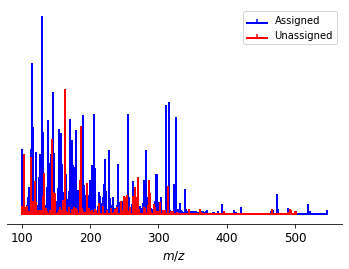

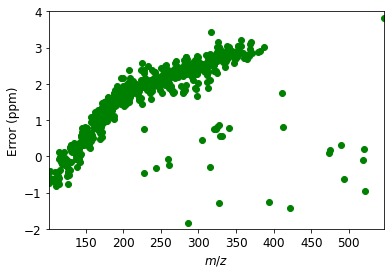

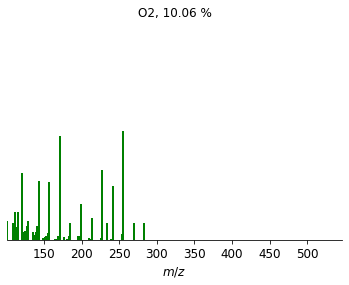

In [11]:
mass_spectrum.molecular_search_settings.error_method = 'None'
mass_spectrum.molecular_search_settings.min_ppm_error = -2
mass_spectrum.molecular_search_settings.max_ppm_error = 4

mass_spectrum.molecular_search_settings.url_database = None
mass_spectrum.molecular_search_settings.min_dbe = 0
mass_spectrum.molecular_search_settings.max_dbe = 50

mass_spectrum.molecular_search_settings.usedAtoms['C'] = (1, 100)
mass_spectrum.molecular_search_settings.usedAtoms['H'] = (4, 200)
mass_spectrum.molecular_search_settings.usedAtoms['O'] = (1, 30)
mass_spectrum.molecular_search_settings.usedAtoms['N'] = (0, 6)
mass_spectrum.molecular_search_settings.usedAtoms['S'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['Cl'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['Br'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['P'] = (0, 0)
mass_spectrum.molecular_search_settings.usedAtoms['Na'] = (0, 0)

mass_spectrum.molecular_search_settings.isProtonated = True
mass_spectrum.molecular_search_settings.isRadical = False
mass_spectrum.molecular_search_settings.isAdduct = False

# mass_spectrum.filter_by_max_resolving_power(15, 2)
SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

mass_spectrum.percentile_assigned(report_error=True)
mass_spectrum.molecular_search_settings.score_method = "prob_score"
mass_spectrum.molecular_search_settings.output_score_method = "prob_score"

# export_calc_isotopologues(mass_spectrum, "15T_Neg_ESI_SRFA_Calc_Isotopologues")

mass_spectrum_by_classes = HeteroatomsClassification(mass_spectrum, choose_molecular_formula=True)

mass_spectrum_by_classes.plot_ms_assigned_unassigned()
plt.show()
mass_spectrum_by_classes.plot_mz_error()
plt.show()
mass_spectrum_by_classes.plot_ms_class("O2")
plt.show()
